In [1]:
import keras
import tensorflow as tf
import pandas as pd
import csv
import statistics as st

import numpy as np
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

C:\Users\nickr\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('Dataset Reviews - Copy.csv', encoding='utf8')
#df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Company                5332 non-null   object
 1   Job Title              5332 non-null   object
 2   Employement Level      5332 non-null   int64 
 3   Review Title           5331 non-null   object
 4   Pros                   5332 non-null   object
 5   Cons                   5332 non-null   object
 6   Rating                 5332 non-null   int64 
 7   Review Title-neg       5332 non-null   int64 
 8   Review Title-neu       5332 non-null   int64 
 9   Review Title-pos       5332 non-null   int64 
 10  Review Title-compound  5332 non-null   int64 
 11  Review Titletoken      5303 non-null   object
 12  Pros-neg               5332 non-null   int64 
 13  Pros-neu               5332 non-null   int64 
 14  Pros-pos               5332 non-null   int64 
 15  Pros-compound        

In [3]:
df.head()

,Company,Job Title,Employement Level,Review Title,Pros,Cons,Rating,Review Title-neg,Review Title-neu,Review Title-pos,...,Pros-neg,Pros-neu,Pros-pos,Pros-compound,Prostoken,Cons-neg,Cons-neu,Cons-pos,Cons-compound,Constoken
0,eBay,Consultant,0,good company,the people and the company culture is warm. lo...,the company is very old fashioned and the proj...,100,0,25,74,...,0,57,42,95,people company culture warm . lot opportunity ...,0,81,18,75,company old fashioned project take long time p...
1,eBay,Authentication Center Generalist,0,a step in the wrong direction,"since ebay's acquisition of my employer, tcgpl...","regrettably, ebay has made a mess of their acq...",25,43,56,0,...,0,65,34,98,"since ebay 's acquisition employer , tcgplayer...",14,80,5,-89,"regrettably , ebay made mess acquisition tcgpl..."
2,eBay,Software Development Engineer (SDE),0,good,good company to work with,cafeteria need to have more choice,100,0,0,100,...,0,57,42,44,good company work,0,100,0,0,cafeteria need choice
3,eBay,Strategic Account Manager,1,good environment,"great culture, good benefits, good options for...","slow, risk adverse, reinvention in progress",75,0,25,74,...,0,49,51,91,"great culture , good benefit , good option emp...",44,28,26,-20,"slow , risk adverse , reinvention progress"
4,eBay,Manager,1,manager,good benefits with good environment,nothing really much to say,75,0,100,0,...,0,19,80,81,good benefit good environment,0,100,0,0,nothing really much say


In [4]:
df['Employement Level'].value_counts()

Employement Level
0    4253
1    1079
Name: count, dtype: int64

In [5]:
df_nums = df.drop(columns=['Company', 'Job Title', 'Review Title', 'Pros', 'Cons', 'Prostoken', 'Constoken', 'Review Titletoken'])

cols = df_nums.columns.tolist()

cols = cols[1:] + cols[0:1]
print(cols)
df_nums = df_nums[cols]

sentenceHeaders = ['Review Title-compound', 'Pros-compound', 'Cons-compound']
for header in sentenceHeaders:
    df_nums[header] = ((df_nums[header] + 100) / 200 * 100)
    df_nums[header] = df_nums[header].astype(int)
    
for header in df_nums.columns.tolist():
    if header == "Employement Level":
        continue
    df_nums[header] = df_nums[header]/100
    
df_nums.to_csv('Dataset Reviews 0 to 1.csv', index=False)  
df_nums.info()

['Rating', 'Review Title-neg', 'Review Title-neu', 'Review Title-pos', 'Review Title-compound', 'Pros-neg', 'Pros-neu', 'Pros-pos', 'Pros-compound', 'Cons-neg', 'Cons-neu', 'Cons-pos', 'Cons-compound', 'Employement Level']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rating                 5332 non-null   float64
 1   Review Title-neg       5332 non-null   float64
 2   Review Title-neu       5332 non-null   float64
 3   Review Title-pos       5332 non-null   float64
 4   Review Title-compound  5332 non-null   float64
 5   Pros-neg               5332 non-null   float64
 6   Pros-neu               5332 non-null   float64
 7   Pros-pos               5332 non-null   float64
 8   Pros-compound          5332 non-null   float64
 9   Cons-neg               5332 non-null   float64
 10  Cons-neu               5332 non-null   fl

In [93]:
df_nums.head()

,Rating,Review Title-neg,Review Title-neu,Review Title-pos,Review Title-compound,Pros-neg,Pros-neu,Pros-pos,Pros-compound,Cons-neg,Cons-neu,Cons-pos,Cons-compound,Employement Level
0,1.00,0.00,0.25,0.74,0.72,0.0,0.57,0.42,0.97,0.00,0.81,0.18,0.87,0
1,0.25,0.43,0.56,0.00,0.26,0.0,0.65,0.34,0.99,0.14,0.80,0.05,0.05,0
2,1.00,0.00,0.00,1.00,0.72,0.0,0.57,0.42,0.72,0.00,1.00,0.00,0.50,0
3,0.75,0.00,0.25,0.74,0.72,0.0,0.49,0.51,0.95,0.44,0.28,0.26,0.40,1
4,0.75,0.00,1.00,0.00,0.50,0.0,0.19,0.80,0.90,0.00,1.00,0.00,0.50,1


Model N is for numerical Data, Model PC is for NLP (P = Pro, C = Con)

In [52]:
def balance_column(df, column_name):
    # Count the occurrences of each value in the specified column
    value_counts = df[column_name].value_counts()
    
    # Find the minimum count between 1's and 0's
    min_count = min(value_counts[0], value_counts[1])
    
    # Filter the DataFrame to include only the first min_count occurrences of 1's and 0's
    balanced_df = pd.concat([df[df[column_name] == 1].head(min_count), df[df[column_name] == 0].head(min_count)])
    
    return balanced_df
balanced_df = balance_column(df_nums, "Employement Level")
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2158 entries, 3 to 1396
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rating                 2158 non-null   float64
 1   Review Title-neg       2158 non-null   float64
 2   Review Title-neu       2158 non-null   float64
 3   Review Title-pos       2158 non-null   float64
 4   Review Title-compound  2158 non-null   float64
 5   Pros-neg               2158 non-null   float64
 6   Pros-neu               2158 non-null   float64
 7   Pros-pos               2158 non-null   float64
 8   Pros-compound          2158 non-null   float64
 9   Cons-neg               2158 non-null   float64
 10  Cons-neu               2158 non-null   float64
 11  Cons-pos               2158 non-null   float64
 12  Cons-compound          2158 non-null   float64
 13  Employement Level      2158 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 252.9 KB


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_title (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 pros_title (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 cons_title (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 title_layer1 (Dense)           (None, 8)            40          ['input_title[0][0]']            
                                                                                           

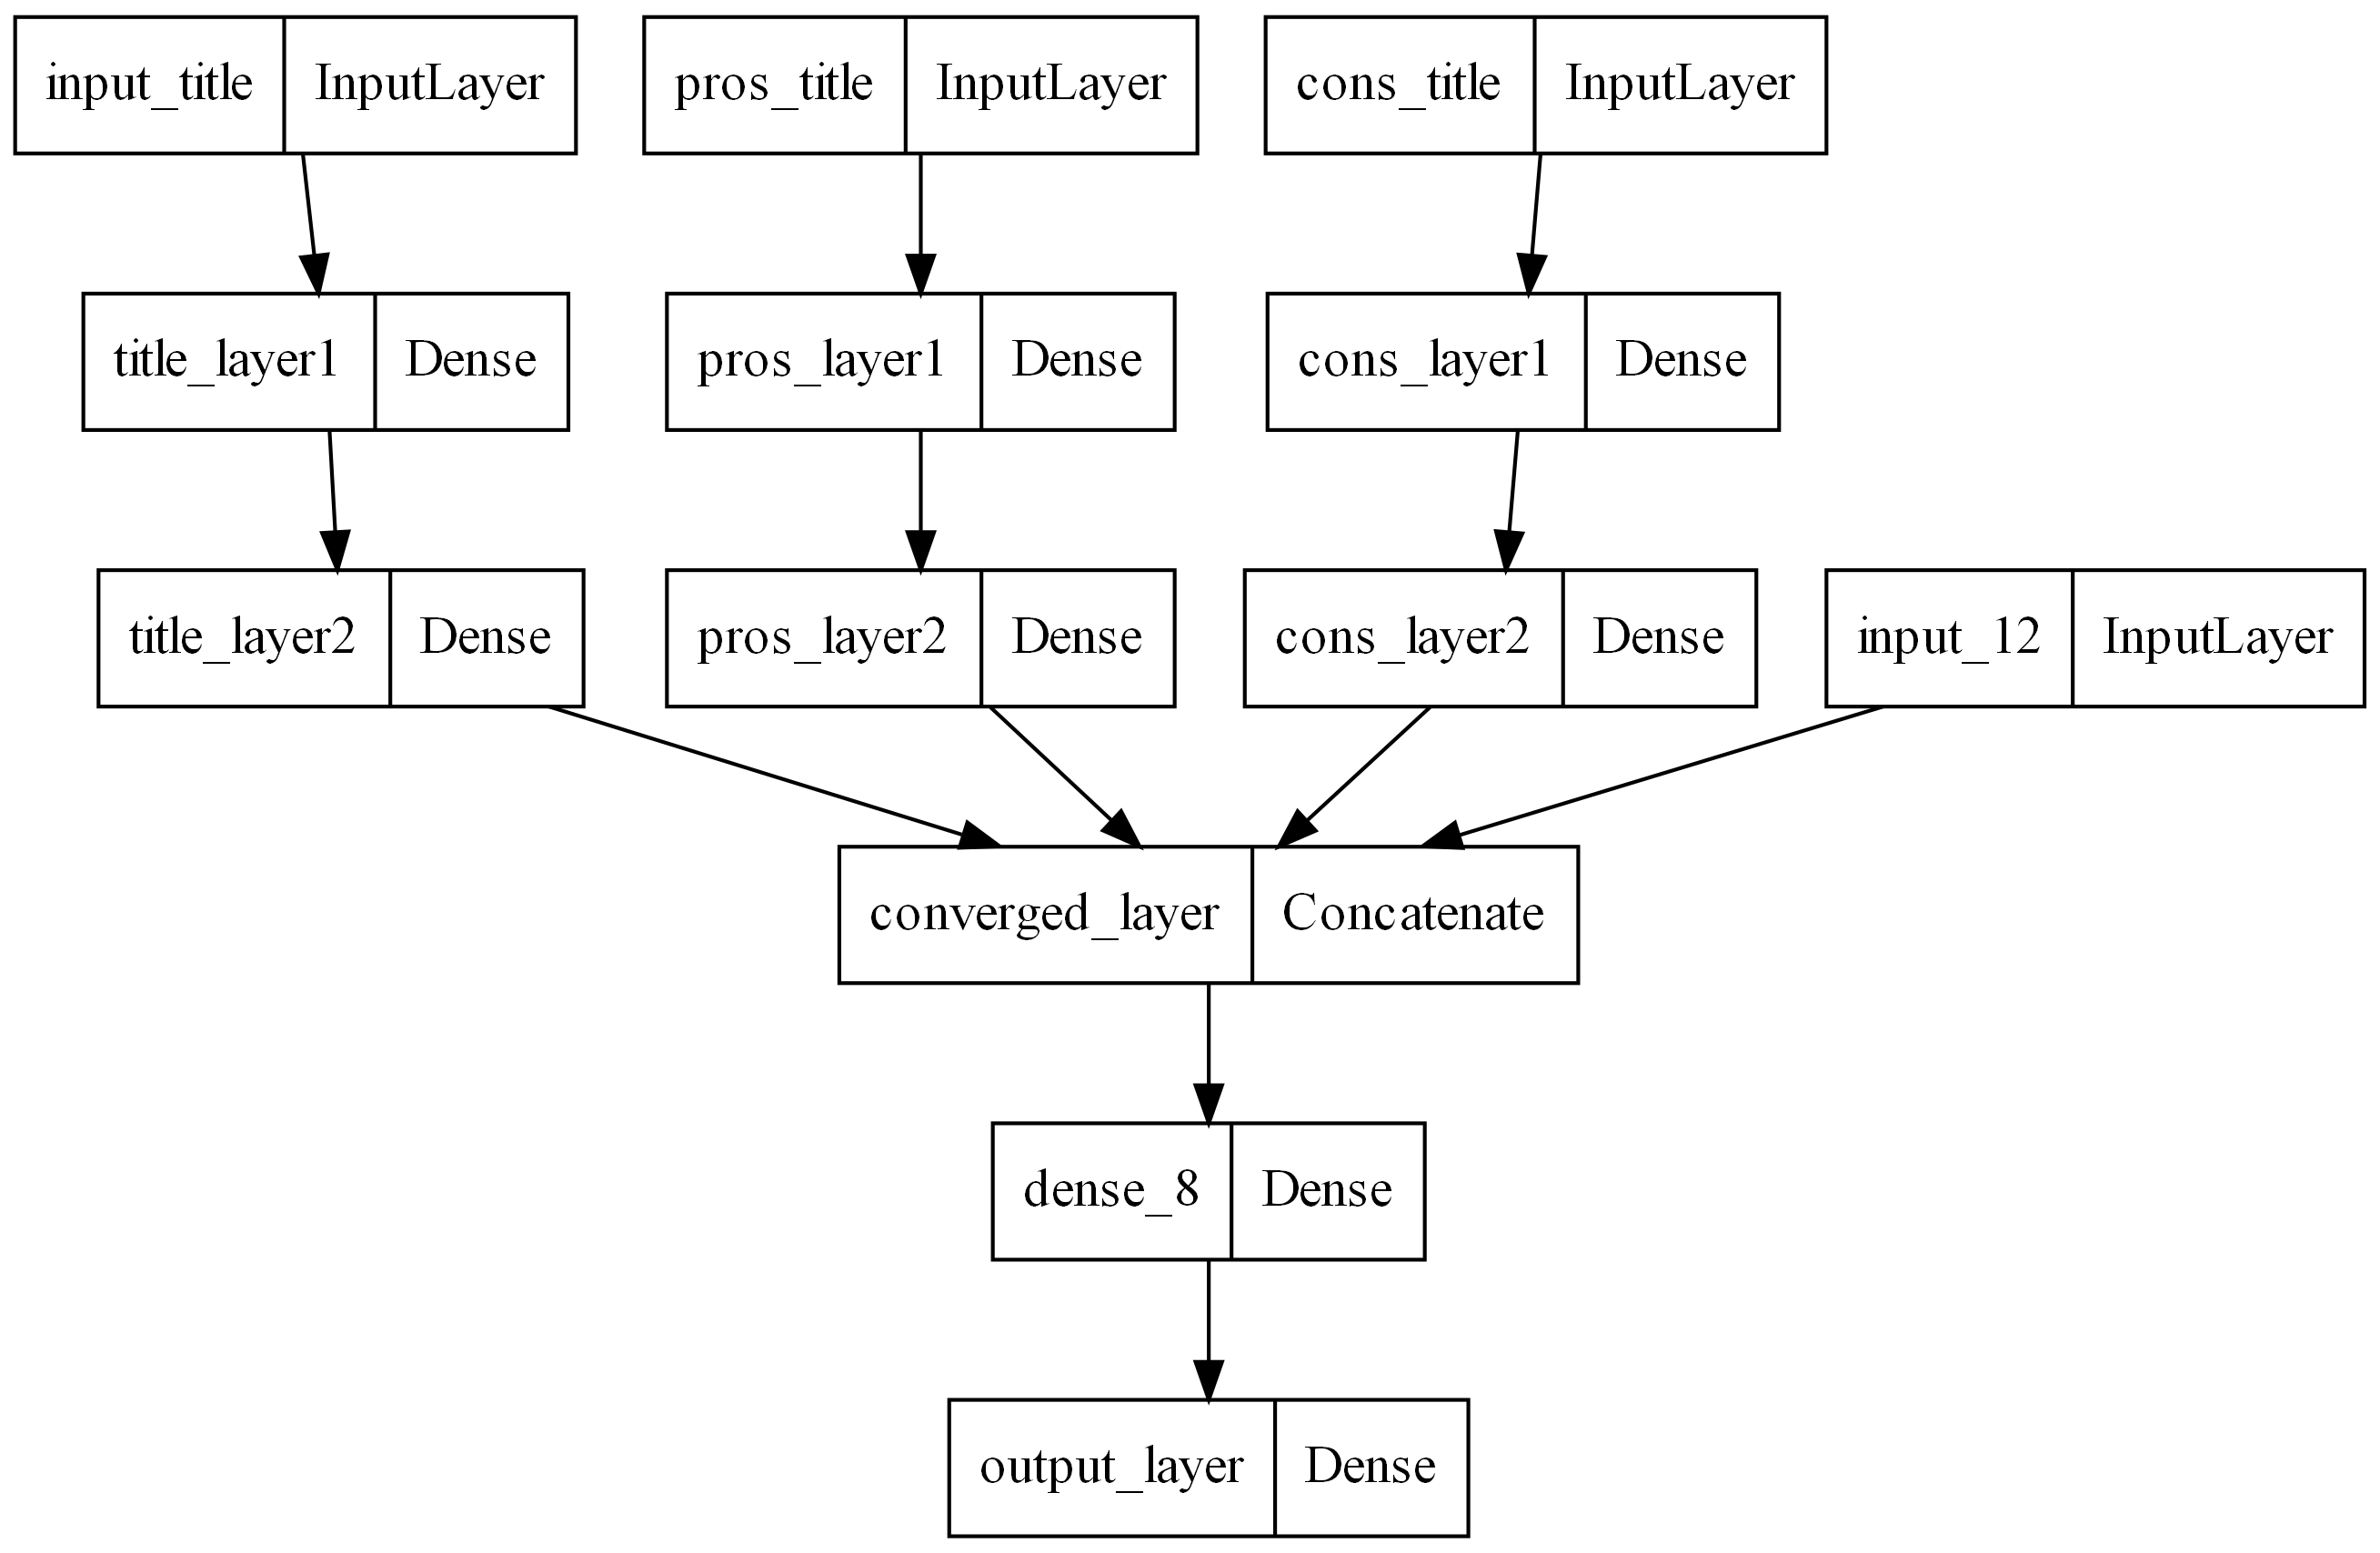

In [171]:
#This is the basic model, using only numerical data
#For best results, use 128 nodes
nodes = 8

inputRating = keras.Input(shape=(1,))
inputT = keras.Input(shape=(4,), name="input_title")
inputP = keras.Input(shape=(4,), name="pros_title")
inputC = keras.Input(shape=(4,), name="cons_title")

t = layers.Dense(units=nodes, name="title_layer1")(inputT)
p = layers.Dense(units=nodes,  name="pros_layer1")(inputP)
c = layers.Dense(units=nodes,  name="cons_layer1")(inputC)

t = layers.Dense(units=nodes,  name="title_layer2")(t)
p = layers.Dense(units=nodes,  name="pros_layer2")(p)
c = layers.Dense(units=nodes,  name="cons_layer2")(c)

tpc = layers.concatenate([t, p, c, inputRating], name="converged_layer")
model = layers.Dense(units=nodes/2)(tpc)
#model =  layers.Dropout(0.5, name="dropout")(tpc)
output = layers.Dense(1, activation="sigmoid", name="output_layer")(model)

model = keras.Model(inputs=[inputRating, inputT, inputP, inputC], outputs= output)


print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True, dpi=300)

In [172]:
def splitData(dataset):
    scaler = StandardScaler()
    #dataset = scaler.fit_transform(dataset)
    trainY= []
    trainR, trainP, trainC, trainT = [], [], [], []
    for row in dataset:
        rowNumpy = row.numpy()
        trainRowX = np.array_split(rowNumpy[1:-1], 3, axis=0)

        trainR.append(rowNumpy[0])
        trainT.append(rowNumpy[1:5])
        trainP.append(rowNumpy[5:9])              
        trainC.append(rowNumpy[9:13])

        trainY.append(rowNumpy[-1])
    #print(row.numpy())
    trainY = np.array(trainY)#.reshape(1,-1)
    trainR = np.array(trainR)
    trainT = np.array(trainT)
    trainP = np.array(trainP)
    trainC = np.array(trainC)
    trainXTogether = [trainR, trainT, trainP, trainC]
    return trainXTogether, trainY

In [173]:
training, testing = keras.utils.split_dataset(df_nums.to_numpy(), left_size=0.8)
trainXTogether, trainY = splitData(training)
testXTogether, testY = splitData(testing)
from keras.optimizers import Adam



unique, counts = np.unique(trainY, return_counts=True)
print(dict(zip(unique, counts)))
print(balanced_df["Employement Level"].value_counts())
#print(trainXTogether[1])

#trainXTogether = [scaler.fit_transform(x)]
#testXTogether = scaler.transform(testXTogether)

epochs = 20
batch = 16

#keras.metrics.Accuracy(name="accuracy", dtype=None)
#metrics=keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),  loss=keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.5), metrics= keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.2) )
model.compile(optimizer=Adam(learning_rate=0.3),  # Adjust the learning rate as needed
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['binary_accuracy'])

history = model.fit(x=trainXTogether, y=trainY, epochs=epochs, batch_size=batch)

{0.0: 3520, 1.0: 746}
Employement Level
1    1079
0    1079
Name: count, dtype: int64
Epoch 1/20
267/267 [==============================] - 2s 5ms/step - loss: 0.7176 - binary_accuracy: 0.8073
Epoch 2/20
267/267 [==============================] - 1s 4ms/step - loss: 0.4721 - binary_accuracy: 0.8251
Epoch 3/20
267/267 [==============================] - 1s 5ms/step - loss: 0.4758 - binary_accuracy: 0.8251
Epoch 4/20
267/267 [==============================] - 1s 5ms/step - loss: 0.4674 - binary_accuracy: 0.8251
Epoch 5/20
267/267 [==============================] - 2s 7ms/step - loss: 62.3198 - binary_accuracy: 0.8031
Epoch 6/20
267/267 [==============================] - 1s 5ms/step - loss: 19.0558 - binary_accuracy: 0.7482
Epoch 7/20
267/267 [==============================] - 1s 5ms/step - loss: 0.6135 - binary_accuracy: 0.7846
Epoch 8/20
267/267 [==============================] - 1s 5ms/step - loss: 0.4936 - binary_accuracy: 0.8183
Epoch 9/20
267/267 [==============================] - 1s

Evaluate on test data
34/34 [==============================] - 0s 3ms/step - loss: 0.7353 - binary_accuracy: 0.6876
test loss, test acc: [0.7352822422981262, 0.6876172423362732]
34/34 [==============================] - 0s 2ms/step
Predicted Count:  {0.0: 1066}
Actual Count:  {0.0: 733, 1.0: 333}
[[0.68761726 0.        ]
 [0.31238274 0.        ]]


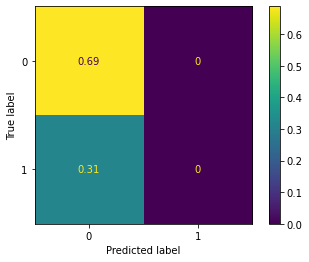

In [174]:
#Predict
print("Evaluate on test data")
results = model.evaluate(testXTogether, testY)
print("test loss, test acc:", results)



y_prediction = model.predict(testXTogether)#.reshape(-1)
#print(y_prediction)
y_prediction[y_prediction <= 0.5] = 0
y_prediction[y_prediction > 0.5] = 1

unique, counts = np.unique(y_prediction, return_counts=True)
print("Predicted Count: ", dict(zip(unique, counts)))

unique, counts = np.unique(testY, return_counts=True)
print("Actual Count: ",dict(zip(unique, counts)))
#testY[testY <= 0.5] = 0
#testY[testY > 0.5] = 1
#print(testY)




#y_prediction.sort(axis=0)
#print(y_prediction)
#y_prediction = np.argmax (y_prediction, axis = 1)
#y_test=np.argmax(testY, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = metrics.confusion_matrix(testY, y_prediction, normalize='pred')
print(result)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [0, 1])

cm_display.plot()
plt.show()

dict_keys(['loss', 'binary_accuracy'])


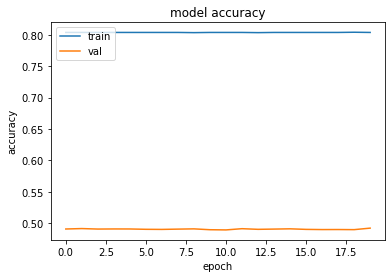

In [147]:
print(history.history.keys())
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

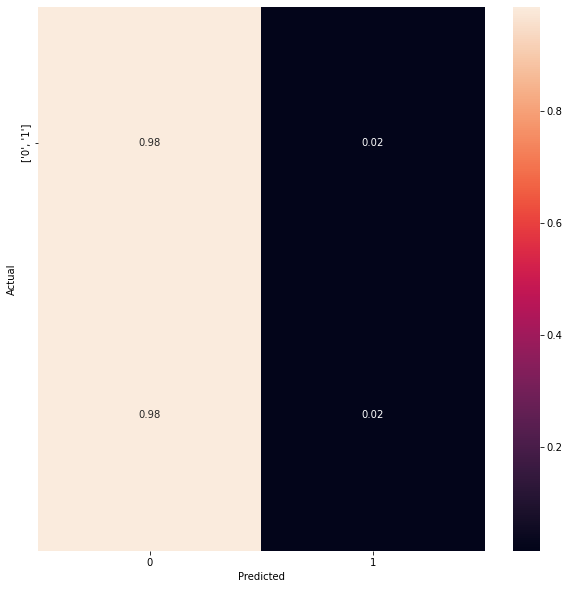

In [157]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm =  metrics.confusion_matrix(testY, y_prediction)# , normalize='pred')
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['0', '1'], yticklabels=[['0', '1']])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)